# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# magic word for producing visualizations in notebook
%matplotlib inline

import math
import time
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.interpolate import make_interp_spline, BSpline
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
import xgboost as xgb
from sklearn.metrics import roc_auc_score

random_seed = 5

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [ ]:
azdias = pd.read_csv("azdias_original.gzip", compression="gzip")
customers = pd.read_csv("customers_original.gzip", compression="gzip")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,NaN,0,0,0,...,NaN,NaN,5.0,1.0,4.0,1.0,6,3,6,6,7,3,5,5,5,4,7,2,3,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8A,8,51,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,0,0,10,0,0,0,10,10,NaN,0,0,0,...,3.0,4.0,1.0,5.0,3.0,5.0,7,2,4,4,4,3,2,3,7,6,4,5,6,1,3,1.0,2.0,0.0,3.0,3.0,1.0,0.0,2,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,4C,4,24,3.0,2.0,4.0,4.0,1.0,3.0,2.0,2.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,2.0,2.0,3.0,5.0,4.0,5.0,7,6,1,7,7,3,4,3,3,4,3,4,3,4,2,0.0,3.0,0.0,2.0,5.0,0.0,1.0,1,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,2A,2,12,2.0,3.0,2.0,2.0,4.0,4.0,5.0,3.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,0.0,3.0,2.0,3.0,2.0,3.0,4,7,1,5,4,4,4,1,4,3,2,5,4,4,1,0.0,1.0,0.0,4.0,5.0,0.0,0.0,1,1.0,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,6B,6,43,5.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3,5,5,1,2,0,10,5,10.0,6,6,1,...,5.0,5.0,5.0,3.0,5.0,5.0,2,4,4,2,3,6,4,2,4,2,4,6,2,7,2,0.0,3.0,0.0,4.0,3.0,0.0,1.0,2,0.0,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [ ]:
print(azdias.shape)
print(customers.shape)

(891221, 366)
(191652, 369)


### 0.1 Data Preprocessing/cleaning

The azdias and custoemr dataframes contains a features with mixed datatypes, missing data and some features contain over 15 types of caegories. Thus to get a clean, complete and effective dataset following steps are done to both dataframes.

1. Get the null value/incomplete data value code (from /DIAS Attributes - Values 2017.xlsx) and convert those values to null in the df.
2. Get the missing value percentage of each feature and drop features which have more than 40% missing data.
3. Get the number of missing values for each row and drop rows which have large missing data. Exact cutoff value to be decided upon inspection of the data.
4. For features containing large number of catagories or object data type, either bin them into suitable sizes, or map them into integers or drop them.  
5. Impute the missing value with the most frequent value for each feature in the azdias dataset.
6. Scale features in to the same range.

In [ ]:
#Get the csv file with null values and the feature data
null_df = pd.read_csv("Null_Values_DIAS_2.csv")

#convert the df to a dictionary
null_dict = null_df.set_index('Attribute').T.to_dict('list')
null_columns = {k:[int(elem) for elem in v if math.isnan(elem)==False] for k,v in null_dict.items()}

In [ ]:
null_columns

{'AGER_TYP': [-1],
 'ALTERSKATEGORIE_GROB': [-1, 0],
 'ALTER_HH': [0],
 'ANREDE_KZ': [-1, 0],
 'BALLRAUM': [-1],
 'BIP_FLAG': [-1],
 'CAMEO_DEUG_2015': [-1],
 'CAMEO_DEUINTL_2015': [-1],
 'CJT_GESAMTTYP': [0],
 'D19_KK_KUNDENTYP': [-1],
 'EWDICHTE': [-1],
 'FINANZTYP': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_VORSORGER': [-1],
 'GEBAEUDETYP': [-1, 0],
 'GEOSCORE_KLS7': [-1, 0],
 'HAUSHALTSSTRUKTUR': [-1, 0],
 'HEALTH_TYP': [-1],
 'HH_EINKOMMEN_SCORE': [-1, 0],
 'INNENSTADT': [-1],
 'KBA05_ALTER1': [-1, 9],
 'KBA05_ALTER2': [-1, 9],
 'KBA05_ALTER3': [-1, 9],
 'KBA05_ALTER4': [-1, 9],
 'KBA05_ANHANG': [-1, 9],
 'KBA05_ANTG1': [-1],
 'KBA05_ANTG2': [-1],
 'KBA05_ANTG3': [-1],
 'KBA05_ANTG4': [-1],
 'KBA05_AUTOQUOT': [-1, 9],
 'KBA05_BAUMAX': [-1, 0],
 'KBA05_CCM1': [-1, 9],
 'KBA05_CCM2': [-1, 9],
 'KBA05_CCM3': [-1, 9],
 'KBA05_CCM4': [-1, 9],
 'KBA05_DIESEL': [-1, 9],
 'KBA05_FR

In [ ]:
#replace null values with np.nan in the df
azdias.replace(null_columns, np.nan, inplace=True)
customers.replace(null_columns, np.nan, inplace=True)

In [ ]:
print(azdias.shape)
print(customers.shape)

(891221, 366)
(191652, 369)


In [ ]:
#function to plot missing values percentage for features.

def plot_missingvalues_percentage(df_list, limit, plot_titles):
    """
    This function will take dataframes and calcualte the missing value percentage of each feature.
    Then plot the percentage above a set limit.
    
    Args: dataframe list, missing value percentage limit to plot, plot titles
    Return: None
    
    """
    Dataset = df_list
    missing_limit = limit   #set the limit for missing values to plot.
    titles = plot_titles
               
    fig, axes = plt.subplots(figsize=(14, 8) , nrows = 1, ncols = len(Dataset))  # Set up the matplotlib figure
    fig.tight_layout(pad=8.0)

    for i,data in enumerate(Dataset):
        feature =[]
        missing_value =[]
        total = data.shape[0]        

        for column in data:
            missing_col = 1-(data[column].count()/total)     #calculate the missing value percentage
            if  missing_col >= missing_limit:
                feature.append(column)
                missing_value.append(missing_col)

        axes[i].barh(y = feature, width=missing_value, height=0.4)  #plot the graph
        axes[i].set(xlabel='Missing Value %')
        axes[i].set_title(titles[i])
        axes[i].vlines(x = 0.4, ymin =feature[0], ymax=feature[-1], colors='r', linestyles='dashed') #add a cutoffline to plot
        for u, v in enumerate(missing_value):
            value = "{:.2f}".format(v)
            axes[i].text(v, u, str(value), color='blue', fontweight='bold') 

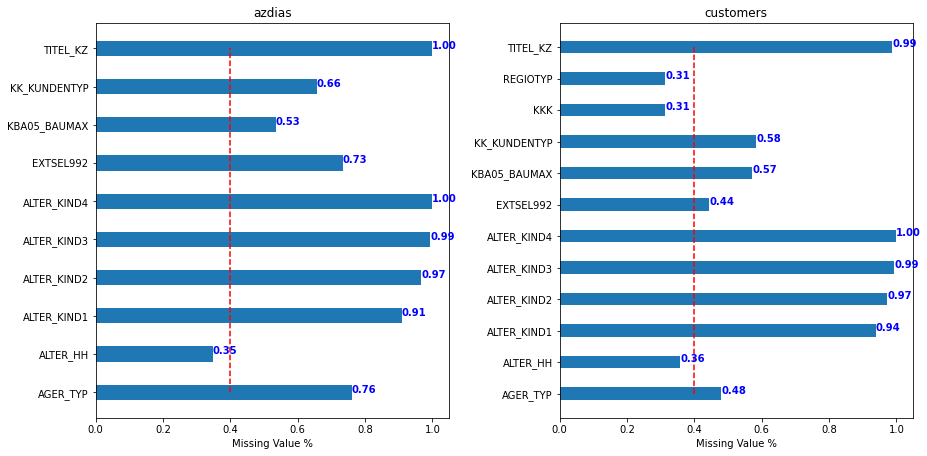

In [ ]:
data_list = [azdias, customers]
data_titles = ['azdias', 'customers']
plot_missingvalues_percentage(data_list, 0.3, data_titles)

**Dropping features with higher missing value**
<br>
For this task, missing value percentage above 40% is dropped from the dfs. 
'AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ' features are dropped from both the dfs.
<br>
In addition 'CUSTOMER_GROUP','PRODUCT_GROUP','ONLINE_PURCHASE'  features are also dropped from the customers dfs.

In [ ]:
#drop columns which have more than 40% missing values from azdias and customers
#drop additional 'CUSTOMER_GROUP','ONLINE_PURCHASE','PRODUCT_GROUP' cloumns from customers

drop_azdias = ['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']
drop_customers = ['CUSTOMER_GROUP','PRODUCT_GROUP','ONLINE_PURCHASE','AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']

azdias.drop(columns= drop_azdias, inplace=True)
customers.drop(columns= drop_customers, inplace=True)

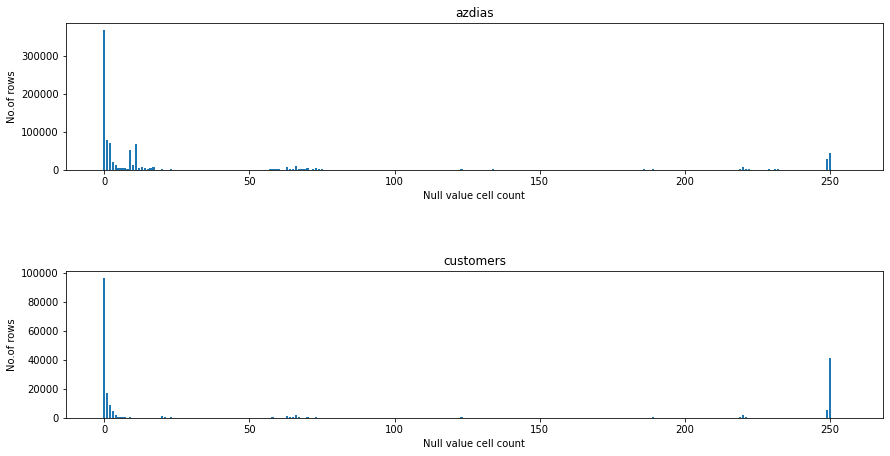

In [ ]:
#plot the rows with the number of null value cell count

Dataset = [azdias, customers]
titles = ['azdias', 'customers']
fig, axes = plt.subplots(figsize=(14, 8) , nrows = len(Dataset), ncols = 1)  # Set up the matplotlib figure
fig.tight_layout(pad=8.0)

for i,data in enumerate(Dataset):
    missing_values_row = data.isnull().sum(axis=1).value_counts().index.tolist()
    missing_counts_row = data.isnull().sum(axis=1).value_counts().values.tolist()      

    axes[i].bar(x= missing_values_row, height=missing_counts_row, width=0.8)  #plot the graph
    axes[i].set(xlabel='Null value cell count')
    axes[i].set(ylabel='No.of rows')
    axes[i].set_title(titles[i])  

Both df has 357 features and 250 is selected as the cutoff value since more than that means the rows do not have 70% of the data.From the graph, we can see customers df has more missing cell values above the cutoff value. It should be noted that droping these rows will still retain majority of the data.

In [ ]:
#drop rows which has more then 250 null cells
azdias.dropna(axis=0, thresh=250, inplace=True)
customers.dropna(axis=0, thresh=250, inplace=True)

In [ ]:
print(azdias.shape)
print(customers.shape)

(785420, 357)
(140371, 357)


The next section will analyse features with object data type and convert data to integers or bin large groups into suitable sizes.

In [ ]:
#get the list of column names with dtype as object
obj_list = azdias.select_dtypes(include='object').columns
obj_list

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [ ]:
obj_list_2 = customers.select_dtypes(include='object').columns
obj_list_2

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

Since object dtype features are same in azdias as well as customers (and later on in the mailout train/test data), function will be written to convert these features. 

Also, 'D19_LETZTER_KAUF_BRANCHE' column will be dropped since no explanation is provided on the attribute in the addiaionl file and looking at the values, it seems like this column contain the group of the last tranctional activty group. Since detail transctional acitivity of individuals are provided in other columns , it is decided to drop this.  

In [ ]:
#convert object dtype columns to ints dtype

def convertobjects(dataset):
    """
    convert object dtype features to integers by mapping.
    args: dataset
    return: None
    
    """
    CAMEO_dict = {"1": 1, "2": 2, "3": 3, "4": 4, "5":5, "6":6, "7":7, "8": 8, "9":9}
    
    #get the first element of the string and map.
    dataset['CAMEO_DEU_2015']= dataset['CAMEO_DEU_2015'].astype(str).str[0].map(CAMEO_dict)
    dataset['CAMEO_DEUG_2015']= dataset['CAMEO_DEUG_2015'].astype(str).str[0].map(CAMEO_dict)
    dataset['CAMEO_INTL_2015']= dataset['CAMEO_INTL_2015'].astype(str).str[0].map(CAMEO_dict)
    
    #extract the first 4 characters as a int
    dataset['EINGEFUEGT_AM']= dataset['EINGEFUEGT_AM'].str[:4].astype('float').astype('Int32')  
    
    dataset['OST_WEST_KZ']= dataset['OST_WEST_KZ'].map({"W":1 , "O":0})

In [ ]:
convertobjects(azdias)
convertobjects(customers)

In [ ]:
azdias.select_dtypes(include='object').columns

Index(['D19_LETZTER_KAUF_BRANCHE'], dtype='object')

In [ ]:
#drop the object dtype columns and LNR
azdias.drop(columns= ['D19_LETZTER_KAUF_BRANCHE','LNR'], inplace=True)
customers.drop(columns= ['D19_LETZTER_KAUF_BRANCHE','LNR'], inplace=True)

In [ ]:
print(azdias.shape)
print(customers.shape)

(785420, 355)
(140371, 355)


Most of the features in the dfs are categorical type. Once the object dtype are succefully convert to ints/floats, the next step is to identify how many categories are there in each feature and if it is too large (high cardinality), reconstruct them in to smaller categories by binning.

In [ ]:
#get the columns with more than 15 categories.
big_category_columns = []
for columns in azdias.columns:
    groups = azdias[columns].nunique()
#     print('{}  ----  {}'.format(columns, groups))
    if groups >15:
        big_category_columns.append(columns)   #list of columns with more than 15 unique data. 
        

In [ ]:
big_category_columns

['ALTER_HH',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'GEBURTSJAHR',
 'KBA13_ANZAHL_PKW',
 'LP_LEBENSPHASE_FEIN',
 'MIN_GEBAEUDEJAHR',
 'VERDICHTUNGSRAUM']

Looking at these columns, 
*   'LP_LEBENSPHASE_FEIN' is the more detailed breakdown of 'LP_LEBENSPHASE_GROB'. Considering 'LP_LEBENSPHASE_FEIN' has over 40 categories, this is dropped from the df.
*   'GEBURTSJAHR' is the year of birth. But it contains value 0 which is not a valid data. Thus, the 0 is converted to a np.nan. Afterwards The distribution graphs of the big_category_columns were plotted to analyse the data. For the plotting azdias data is selected as it represents the general population.



In [ ]:
#droping the 'LP_LEBENSPHASE_FEIN' feature
azdias.drop(columns= ['LP_LEBENSPHASE_FEIN'], inplace=True)
customers.drop(columns= ['LP_LEBENSPHASE_FEIN'], inplace=True)

In [ ]:
#converting value 0 of 'GEBURTSJAHR' feature to np.nan
azdias['GEBURTSJAHR'].replace(0, np.nan, inplace=True)   #update the null coiumn value
customers['GEBURTSJAHR'].replace(0, np.nan, inplace=True)   #update the null coiumn value

In [ ]:
# Set up the matplotlib figure for the disribution of big_category_columns

def distribution_graphs(features):
    fig, axes = plt.subplots(figsize=(12, 7) , nrows = 3, ncols = 4)
    fig.tight_layout(pad=4.0)

    for i in range(12):
        if i<4:
            axes[0,i].hist(x=azdias[features[i]].dropna(), color = 'blue', edgecolor = 'black')
            axes[0,i].set_title('{}'.format(features[i]))
        elif 4<=i<8:
            axes[1,i-4].hist(x=azdias[features[i]].dropna(), color = 'blue', edgecolor = 'black')
            axes[1,i-4].set_title('{}'.format(features[i]))
        elif 8<=i<12:   
            axes[2,i-8].hist(x=azdias[features[i]].dropna(), color = 'blue', edgecolor = 'black')
            axes[2,i-8].set_title('{}'.format(features[i]))

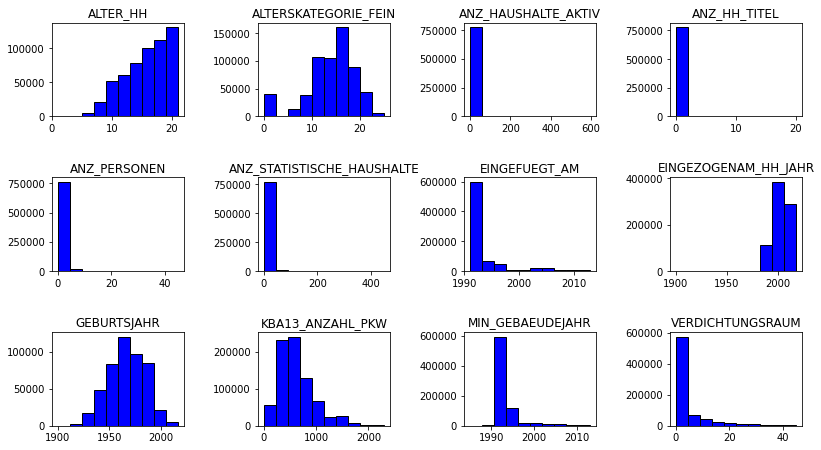

In [ ]:
big_category_columns.remove('LP_LEBENSPHASE_FEIN')
distribution_graphs(big_category_columns)

From the distribution graphs, we can see ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN' and 'ANZ_STATISTISCHE_HAUSHALTE', 'EINGEFUEGT_AM', 'VERDICHTUNGSRAUM', 'MIN_GEBAEUDEJAHR' features are highly skewed. Also, 'EINGEFUEGT_AM','EINGEZOGENAM_HH_JAHR','GEBURTSJAHR' and 'MIN_GEBAEUDEJAHR' has year values for data. 

All of these features are reconstrued to cateogorical bins of levels <=10. The bin sizes/limits are decided by the azdias data. Once the bins are selected customers data is transformed according to those limits. For non skewed data bin limits are decied based on the quantile mathod. (e.g. value, bins = pd.qcut(azdias['feature'], q=10, retbins=True)

In [ ]:
#function for reconstructing big_cateogrory columns to smaller number of levels.

def reconstruct_big_cateogory(df):
    """
    Reconstruct the large categorical features to levels <=10
    args: dataframe
    return:None
    
    """
    cut_10_labels= [1,2,3,4,5,6,7,8,9,10]
    df['ALTER_HH_2']= pd.cut(x= df['ALTER_HH'], bins=[0,10,12,13,15,16,17,18,19,20,21], labels = cut_10_labels)   
    df['ALTERSKATEGORIE_FEIN_2']= pd.cut(x= df['ALTERSKATEGORIE_FEIN'], bins=[-1,8,10,12,13,14,15,17,18,19,25], labels = cut_10_labels)
    df['EINGEZOGENAM_HH_JAHR_2']= pd.cut(x= df['EINGEZOGENAM_HH_JAHR'], bins=[1899,1994,1997,1998,2001,2003,2005,2008, 2012,2014,2018], labels = cut_10_labels)
    df['KBA13_ANZAHL_PKW_2']= pd.cut(x= df['KBA13_ANZAHL_PKW'], bins=[-1,263,347,417,482,549,623,719,851,1070,2300], labels = cut_10_labels)
    df['GEBURTSJAHR_2']= pd.cut(x= df['GEBURTSJAHR'], bins=[1899,1942,1951,1958,1963,1967,1972,1978,1983,1990,2017], labels = cut_10_labels)
    df['EINGEFUEGT_AM_2']= pd.cut(x= df['EINGEFUEGT_AM'], bins=[1990,1992,1993,1994,1995,1996,1997,2002,2004,2005,2013], labels = cut_10_labels)
    df['MIN_GEBAEUDEJAHR_2']= pd.cut(x= df['MIN_GEBAEUDEJAHR'], bins=[1985,1991,1992,1993,1994,1995,1996,1997,2000,2004,2013], labels = cut_10_labels)
    df['VERDICHTUNGSRAUM_2']= pd.cut(x= df['VERDICHTUNGSRAUM'], bins=[-1,0,1,2,3,4,7,11,15,30,45], labels = cut_10_labels)
    
    cut_7_labels =  [1,2,3,4,5,6,7]
    df['ANZ_HAUSHALTE_AKTIV_2']= pd.cut(x= df['ANZ_HAUSHALTE_AKTIV'], bins=[-1,1,2,3,5,9,14,595], labels = cut_7_labels)
    df['ANZ_STATISTISCHE_HAUSHALTE_2']= pd.cut(x= df['ANZ_STATISTISCHE_HAUSHALTE'], bins=[-1,1,2,3,5,8,13,449], labels = cut_7_labels)
    df['ANZ_PERSONEN_2']= pd.cut(x= df['ANZ_PERSONEN'], bins=[-1,0,1,2,3,4,5,46], labels = cut_7_labels)
    
    cut_8_labels =  [0,1,2,3,4,5,6,7]
    df['ANZ_HH_TITEL_2']= pd.cut(x= df['ANZ_HH_TITEL'], bins=[-1,0,1,2,3,4,5,8,23], labels = cut_8_labels)   

In [ ]:
#reconstruct the dfs
reconstruct_big_cateogory(azdias)
reconstruct_big_cateogory(customers)

In [ ]:
reconstruct_cat_columns = ['ALTER_HH_2','ALTERSKATEGORIE_FEIN_2','ANZ_HAUSHALTE_AKTIV_2','ANZ_HH_TITEL_2','ANZ_PERSONEN_2',
                     'ANZ_STATISTISCHE_HAUSHALTE_2','EINGEFUEGT_AM_2','EINGEZOGENAM_HH_JAHR_2','GEBURTSJAHR_2',
                     'KBA13_ANZAHL_PKW_2','MIN_GEBAEUDEJAHR_2','VERDICHTUNGSRAUM_2']

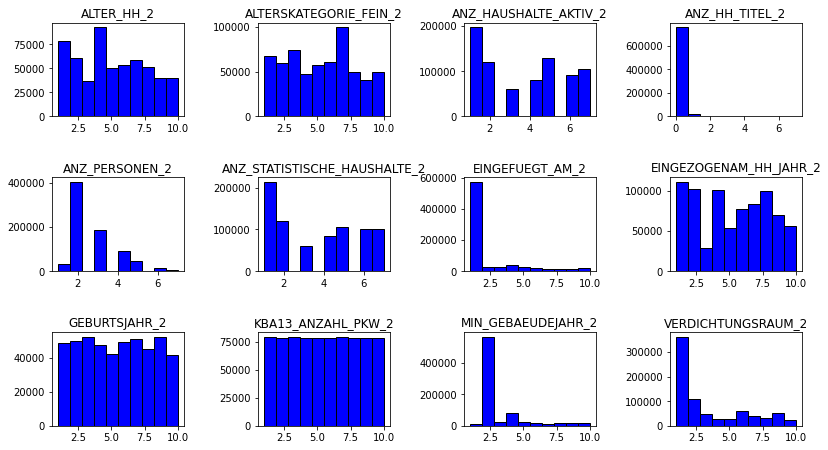

In [ ]:
distribution_graphs(reconstruct_cat_columns)

The leves of the new features are now at a suitable range. So the big_category_columns are dropped from the dfs.

In [ ]:
#drop  big_category_columns from the dfs
azdias.drop(columns=  big_category_columns, inplace=True)
customers.drop(columns=  big_category_columns, inplace=True)

In [ ]:
print(azdias.shape)
print(customers.shape)

(785420, 354)
(140371, 354)


Moving to the last two steps in the data processing. The next step is to impute the missing value with the most frequent value for each feature. For each feature, frequnet value is seleced by the azdias dataset since it represents the population at large and that value is used to fill the cusotmers missing data as well. 

In [ ]:
#get the most frequent value for each feature and create a dictionary
frequent_dict = {}
for columns in azdias.columns:
  frequent_dict[columns] = azdias[columns].mode().iloc[0]
  

In [ ]:
#fill dfs with the most frequent values  
azdias.fillna(value=frequent_dict, inplace=True)
customers.fillna(value=frequent_dict, inplace=True)

In [ ]:
#checking for null columns
# checklist = azdias.columns[azdias.isna().any()].tolist()
# checklist

[]

In [ ]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 785420 entries, 1 to 891220
Columns: 354 entries, AKT_DAT_KL to ANZ_HH_TITEL_2
dtypes: category(12), float64(256), int64(86)
memory usage: 2.0 GB


In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140371 entries, 0 to 191651
Columns: 354 entries, AKT_DAT_KL to ANZ_HH_TITEL_2
dtypes: category(12), float64(256), int64(86)
memory usage: 368.9 MB


In [28]:
#save the cleaned file
# azdias.to_csv("azdias_cleaned.gzip",index = False, compression="gzip")
# customers.to_csv("customers_cleaned.gzip",index = False, compression="gzip")

#open the cleaned data
# azdias = pd.read_csv("azdias_cleaned.gzip", compression="gzip")
# customers = pd.read_csv("customers_cleaned.gzip", compression="gzip")

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [29]:
feature_list = azdias.columns  #get the feature names

Before applying PCA, feature shoould be scaled to a uniform size. In this case Min Max scaler is used.

In [30]:
#scaling the df using minmaxscaler
scaler = MinMaxScaler()
scaler.fit(azdias)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [31]:
azdias = scaler.transform(azdias)
customers = scaler.transform(customers)

### 1.1 PCA

In [35]:
#function to model pca and plot the variance

def pca_variance(dataframe, components): 

  """
  calculate the explained variance and plot the variance with the pca componenet number
  args: dataframe/array, pca_components number
  return: None  
  """
  variance = []
  for value in components:
      pca_model = PCA(n_components=value)  #model the pca
      pca_model.fit_transform(dataframe)   
      variance.append(pca_model.explained_variance_ratio_.cumsum()[value-1])  #get the variace value
      print(pca_model.explained_variance_ratio_.cumsum()[value-1])
  print(variance)
  print(components)
      
  #plot the variace
  components_smooth = np.linspace(components[0], components[-1], 10)  #10 points are selected to get a smooth line
  spl = make_interp_spline(components, variance, k=3)  # type: BSpline
  varaince_smooth = spl(components_smooth)
  
  plt.scatter(components, variance)   #plot the variance as a scatter graph
  plt.plot(components_smooth, varaince_smooth)  #plot the smooth line
  plt.ylabel("Variance Covered")
  plt.xlabel("PCA Components")
  plt.title("Variance covered by PCA Components")
  plt.show()

0.8534275636952924
0.8863019460905036
0.9131666289781691
0.9347333415629413
[0.8534275636952924, 0.8863019460905036, 0.9131666289781691, 0.9347333415629413]
[130, 150, 170, 190]


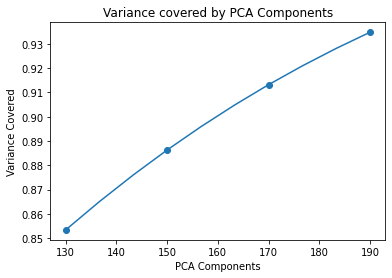

In [ ]:
#apply pca
pca_components = [130, 150,170, 190]
pca_variance(azdias,pca_components)

Considering the total variace captured by principal components, 170 PCA components is selected as it covers above 90% of the total variance.

In [36]:
#select the pca_component and transform the dataset

pca_model = PCA(n_components=170)

azdias_transformed = pca_model.fit_transform(azdias)
customers_transformed = pca_model.transform(customers)

In [ ]:
#save the transformed file
# pd.DataFrame(azdias_transformed).to_csv("azdias_transformed.gzip",index = False, compression="gzip")
# pd.DataFrame(customers_transformed).to_csv("customers_transformed.gzip",index = False, compression="gzip")

#open the transformed files
# azdias_transformed = pd.read_csv("azdias_transformed.gzip",compression='gzip')
# customers_transformed = pd.read_csv("customers_transformed.gzip",compression='gzip')

### 1.2 Elbow method

Too high clusters points will fail to capture the patterns of clusters and overfit. To select the optimum cluster size elbow method is used. This is a common heuristic mathematical optimisation method in which it calucate the sum of squared distances from each point to its assigned center. The elbow act as a cutoff point where the additioanl clusters will not significanlty reduce the cost.

In [ ]:
# calcualte the SSD for the optimum k for k-means
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(3,12)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(azdias_transformed)
    Sum_of_squared_distances.append(km.inertia_)

print(Sum_of_squared_distances)

[18122589.056397907, 17643776.05023587, 17275167.16116114, 17013594.43496224, 16783384.56645064, 16609821.431585163, 16458156.700706284, 16329332.757143894, 16208475.838180523]


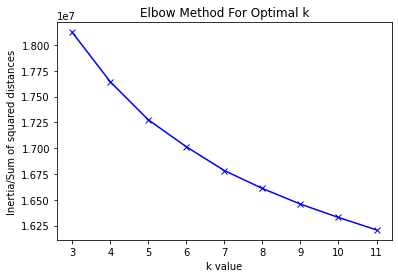

In [ ]:
#plot the elbow graph
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k value')
plt.ylabel('Inertia/Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### 1.3 K-means clustering
Based on the elbow graph, 7 is seleced as a good cluster(k) size.

In [37]:
#apply kmenas clustering method for the dataset

cluster_model = KMeans(n_clusters=7).fit(azdias_transformed )  #selected cluster size is 7
azdias_cluster = cluster_model.predict(azdias_transformed )
customers_cluster = cluster_model.predict(customers_transformed)

azdias_cluster and the customers_cluster represent the individuals cluster number. To analyse these cluster ans identify trends bettwen clusters and general polulation(azdias) following graphs are plotted.


In [38]:
#get the azdias cluster points count
clusterpoint_azdias, azdias_counts = np.unique(azdias_cluster, return_counts=True)
print(clusterpoint_azdias)
print(azdias_counts)

[0 1 2 3 4 5 6]
[ 82145 131044 114524 139250 120396 118405  79656]


In [39]:
#get the custoemrs cluster points count
clusterpoint_customers, customers_counts = np.unique(customers_cluster, return_counts=True)
print(clusterpoint_customers)
print(customers_counts)

[0 1 2 3 4 5 6]
[44686  1409  1723 37486 18087 31158  5822]


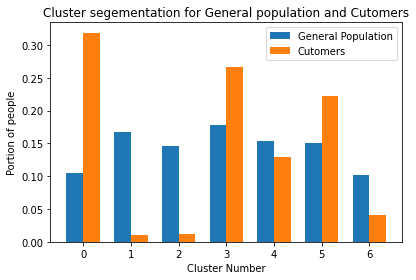

In [40]:
#plot cluster graphs for azdias and customers

cluster_label = np.arange(len(clusterpoint_azdias))  # the label locations
width = 0.35  # the width of the bars

cluster_fig, cluster_ax = plt.subplots()
chart1 = cluster_ax.bar(cluster_label - width/2, azdias_counts/azdias_counts.sum(), width, label='General Population')
chart2 = cluster_ax.bar(cluster_label + width/2, customers_counts/customers_counts.sum(), width, label='Cutomers')

# Add some text for labels, title and custom x-axis tick labels, etc.
cluster_ax.set_ylabel('Portion of people')
cluster_ax.set_title('Cluster segementation for General population and Cutomers')
cluster_ax.set_xlabel('Cluster Number')
cluster_ax.set_xticks(cluster_label)
cluster_ax.set_xticklabels(cluster_label)
cluster_ax.legend()
cluster_fig.tight_layout()

plt.show()

From the above graphs it can be seen, the general population is approximatley evenly distributed among the 7 clusters. From these clusters, customers are mostly located in cluster 1, 4 and 6 while cluster 0,2 and 3 has the lowest number of customer representation. To better analyse, this ratio of the clusters(customers/general population) is plotted.

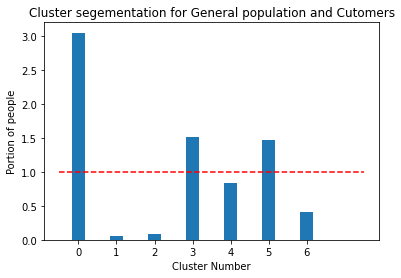

In [41]:
#plot the ratio for each cluster graph

cluster_ratio = (customers_counts/customers_counts.sum())/(azdias_counts/azdias_counts.sum()) #calculate the ratio

ratio_chart = plt.bar(cluster_label, cluster_ratio,width)
plt.ylabel('Portion of people')
plt.title('Cluster segementation for General population and Cutomers')
plt.xlabel('Cluster Number')
plt.hlines(y=1, xmin=-0.5, xmax=7.5, colors='r',linestyles='dashed')
plt.xticks(cluster_label)
plt.show()

The Ratio of customers to general population provids an insight in to which cluster of the population should be targeted by arvato. If this ratio is more than 1, it indicates that there is a higher portion of customers present in that cluster and most importantly higher probablity that poeple in that cluster will become future customers.

In [42]:
#composition of pca components and clusters

pca_composition = pca_model.components_  #arr of feature weights of the pca components(170 x 354)

In [48]:
#function to plot the pca composition.

def display_component(pca_composition, features_list, component_num, n_weights):
    """
    plot the top n composition/features of a given pca component.
    args: 
        pca_composition = arr of features weights of the pca components
        features_list = list of feature names
        component_num = the pca component that need to be plotted
        n_weights = the number of top features to analyse
    return : None

    """

    weights  = pca_composition[component_num-1]  #weights list for each feature for a given pca component
    # match weights to features in azdias using list comporehension
    weight_df = pd.DataFrame(list(zip(weights, features_list)), 
                         columns=['weights', 'features'])
    weight_df['abs_weights']=weight_df['weights'].apply(lambda x: np.abs(x)) #get the abs value of the weights
    sorted_weight_df = weight_df.sort_values('abs_weights', ascending=False).head(n_weights) #sort based on the largest abs value
   

    # display the pca component plot
    ax=plt.subplots(figsize=(8,4))
    ax=sns.barplot(data=sorted_weight_df, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component composition : Component #" + str(component_num))
    plt.show()

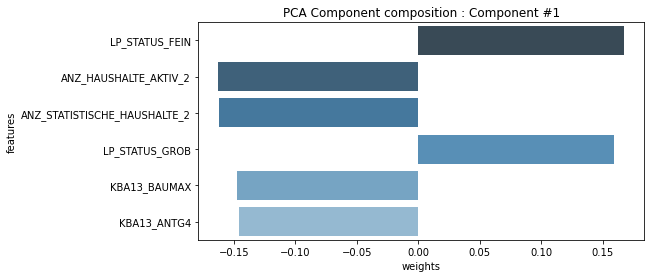

In [49]:
display_component(pca_composition, feature_list, component_num= 1, n_weights = 6)

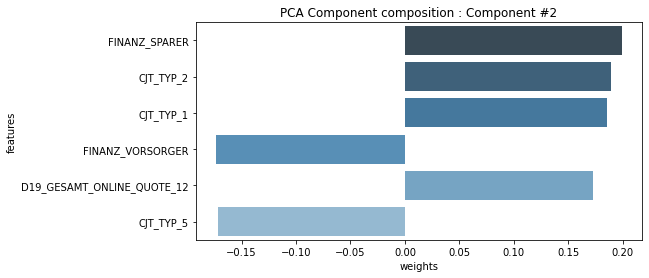

In [50]:
display_component(pca_composition, feature_list, component_num= 2, n_weights = 6)

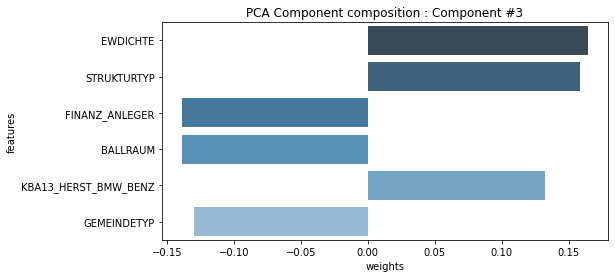

In [51]:
display_component(pca_composition, feature_list, component_num= 3, n_weights = 6)

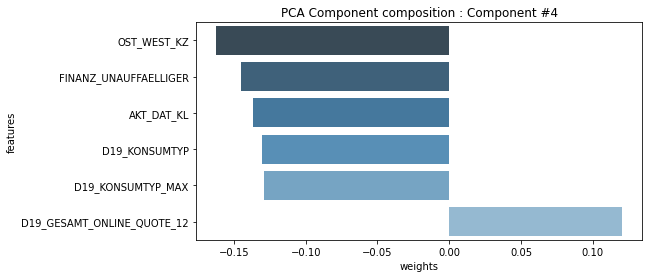

In [52]:
display_component(pca_composition, feature_list, component_num= 4, n_weights = 6)

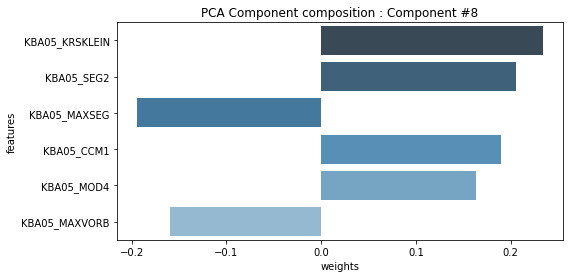

In [61]:
display_component(pca_composition, feature_list, component_num= 8, n_weights = 6)

PCA_Component 1:
1.   It has a high positive weight for LP_STATUS_FEIN (LP_STATUS_GROB is the rough estimate of the same feature) which represents the social status of an individual.
2.   The largest negative weights are for ANZ_HAUSHALTE_AKTIV, KBA13_BAUMAX and KBA13_ANTG4. Although exact explanation is not provided for all features, based on other similar naming varibales it can be said that 'HAUSHALTE' features represent the number of household details and 'KBA13' features represents the share of cars.

In [53]:
#analyse the cluster composition
cluster_composition = cluster_model.cluster_centers_ #arr of pca weights of the clusters(7 x170)

def analyse_cluster(cluster_composition, cluster_num, n_components):
    """
    Show the top n PCA components for a given cluster
    args:
          cluster_composition = arr of pca weights of the cluster
          cluster_num = number of cluster to be evaluated
          n_components = number of top PCA components to show
    Return: None

    """

    cluster_weights  = cluster_composition[cluster_num]  #pca component weights for the selected cluster
    cluster_df = pd.DataFrame(list(cluster_weights),columns=['pca_weights'])
    cluster_df['component']= cluster_df.index +1 #get the component number 
    cluster_df['abs_pca_weights']= cluster_df['pca_weights'].apply(lambda x: np.abs(x)) #get the abs value of the pca_weights
    sorted_cluster_df = cluster_df.sort_values('abs_pca_weights', ascending=False).head(n_components) #sort based on the largest abs value
       
    top_components = sorted_cluster_df['component'].tolist()
    print("Top {} PCA components for the cluster {} are :{}".format(n_components,cluster_num,top_components))
   

In [60]:
#analyse the top pca components for each cluster

analyse_cluster(cluster_composition, cluster_num= 0, n_components=5)
analyse_cluster(cluster_composition, cluster_num= 1, n_components=5)
analyse_cluster(cluster_composition, cluster_num= 2, n_components=5)
analyse_cluster(cluster_composition, cluster_num= 3, n_components=5)
analyse_cluster(cluster_composition, cluster_num= 4, n_components=5)
analyse_cluster(cluster_composition, cluster_num= 5, n_components=5)
analyse_cluster(cluster_composition, cluster_num= 6, n_components=5)


Top 5 PCA components for the cluster 0 are :[3, 1, 2, 4, 6]
Top 5 PCA components for the cluster 1 are :[4, 3, 1, 2, 11]
Top 5 PCA components for the cluster 2 are :[1, 2, 8, 7, 5]
Top 5 PCA components for the cluster 3 are :[1, 2, 4, 6, 11]
Top 5 PCA components for the cluster 4 are :[1, 2, 4, 3, 11]
Top 5 PCA components for the cluster 5 are :[2, 1, 3, 11, 8]
Top 5 PCA components for the cluster 6 are :[2, 4, 3, 1, 10]


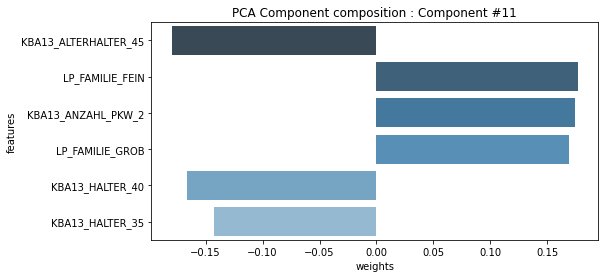

In [62]:
display_component(pca_composition, feature_list, component_num= 11, n_weights = 6)

The top PCA component for cluster 1 (the higherst customer to general population cluser) is PCA ccomponent 3. Analysing that PCA component, we can see the top 3 positive features are 'EWDICHTE','STRUKTURYTP' and 'KBA13_HERST_BMW_BENZ'.  'EWDICHTE' stands for density of inhabitants per square kilometer while 'KBA13_HERST_BMW_BENZ' stands for the share of BMW & Mercedes Benz. The 3 most negative features are 'FINANZ_ANLEGER', 'BALLRAUM' and 'GEMEINDETYP'. The first two of the negative features stands for financial typology: investor and distance to the next metropole, respectively. The 'GEMEINDETYP' could mean the local community type, but it was not provided in the attribute file.  

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
#open the training data file
mailout_train = pd.read_csv("mailout_train.gzip",compression='gzip')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### 2.1 Initial Data Analysis

In [ ]:
print(mailout_train.shape)
mailout_train.head()

(42962, 367)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,5.0,5D,5,34,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,5.0,5.0,2.0,5.0,1.0,6,7,2,6,6,1,7,1,3,2,1,5,1,3,3.0,0.0,3.0,NaN,2.0,4.0,0.0,4.0,2.0,1.0,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1.0,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,5.0,5B,5,32,2.0,2.0,2.0,2.0,4.0,3.0,5.0,4.0,1,1,5,0,0,3,10,10,0.0,0,0,6,...,1.0,2.0,3.0,1.0,3.0,6,6,1,5,6,3,6,5,5,4,3,1,3,4,2.0,0.0,1.0,NaN,2.0,5.0,0.0,0.0,1.0,1.0,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1.0,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,1.0,2D,2,14,4.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,1,7,0,0,0,10,7,0.0,5,0,0,...,4.0,3.0,1.0,5.0,2.0,3,3,4,1,3,4,7,6,1,1,5,3,1,7,3.0,0.0,3.0,NaN,1.0,5.0,0.0,10.0,1.0,4.0,1.0,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2.0,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,2.0,2D,2,14,2.0,5.0,2.0,2.0,5.0,5.0,5.0,4.0,0,0,10,0,0,0,10,10,0.0,0,0,6,...,3.0,5.0,2.0,5.0,1.0,5,7,1,6,7,1,7,1,4,2,2,5,3,2,1.0,0.0,3.0,NaN,3.0,5.0,0.0,5.0,2.0,1.0,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2.0,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,4.0,7B,7,41,6.0,5.0,1.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,5,0,...,3.0,5.0,1.0,5.0,1.0,5,4,6,2,5,5,6,6,4,5,4,6,2,7,1.0,0.0,3.0,NaN,2.0,5.0,0.0,4.0,1.0,0.0,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [ ]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(273), int64(88), object(6)
memory usage: 120.3+ MB


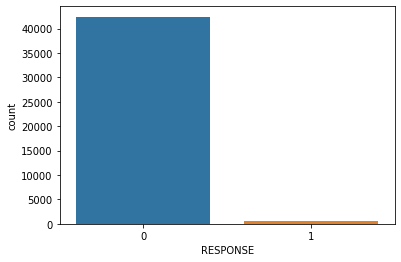

In [ ]:
#response of the customers
sns.countplot(mailout_train['RESPONSE'])

From the response data of the training data, it is evident the data is highly imbalanced with more data with negative reponses. Thus, as an evaluation metric ROC curve is used.

In [ ]:
def similarity_azdias_mailout (df, azdias_missing_cols, azdias_cat_cols):
  """
  check the data similarity(missing value and large categorical columns) between azdias df and a given df
  args: 
    df = df to be checked for similarity 
    azdias_missing_cols= missing columns (>40%) for azdias
    azdias_cat_cols = large categorical columns of azdias
  return: 
    missing_mailout: missing column list for the df
    cat_columns: large categorical column list for the df
  """
 
  missing_mailout =[]   #above 35% missing value columns list
  cat_columns = []  #columns with more than 15 categories
  total = df.shape[0] 

  for columns in df.columns:
    missing_col = 1-(df[columns].count()/total)  
    if  missing_col >= 0.35:      
      missing_mailout.append(columns)

    else:                       #cut off missing columns dropped before getting cat_columns
      groups = df[columns].nunique()  
      if groups >15:
        cat_columns.append(columns)


  diff_miss_cols = list(set(list(set(missing_mailout)-set(azdias_missing_cols))+
                            list(set(azdias_missing_cols)-set(missing_mailout))))
  if diff_miss_cols:
    print('Missing columns list difference between azdias -- features: {}'.format(diff_miss_cols))
  else:
    print('Missing columns list is similar to azdias')
  
  diff_cat_cols = list(set(list(set(cat_columns)-set(azdias_cat_cols))+
                            list(set(azdias_cat_cols)-set(cat_columns))))  
  if diff_cat_cols:
    print('Large categorical column list difference between azdias -- features: {}'.format(diff_cat_cols))
  else:
    print('Large categorical column list is similar to azdias')  

  return missing_mailout, cat_columns

In [ ]:
#azdias data columns data
drop_azdias = ['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']
big_category_columns = ['ALTER_HH','ALTERSKATEGORIE_FEIN','ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_STATISTISCHE_HAUSHALTE',
                        'EINGEFUEGT_AM','EINGEZOGENAM_HH_JAHR','GEBURTSJAHR','LP_LEBENSPHASE_FEIN','KBA13_ANZAHL_PKW','MIN_GEBAEUDEJAHR','VERDICHTUNGSRAUM']              

In [ ]:
#check the similarity between azdias and the mailout
missing_mailout, cat_columns = similarity_azdias_mailout (mailout_train,drop_azdias,big_category_columns)     
            

Missing columns list is similar to azdias
Large categorical column list difference between azdias -- features: ['D19_LETZTER_KAUF_BRANCHE', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'CAMEO_DEUG_2015', 'ANZ_PERSONEN', 'ANZ_HH_TITEL', 'LNR']


From the data it can be seen that mailout data is simialr to the azdias data.
1.   Missing data columns is same as the azdias missing data columns that were dropped. Slight adjustment is made on the cutoff value in the function (0.35 instead of 0.4). This was made to accomadate 'EXTESEL992' which has a missing values percentage of over 37%.

2.   From the large categorical columns, there is a difference between 7 feautres. 3 features include to 'CAMEO_', which are object data type and can undergo the defined convertobject function. The two features,'D19_LETZTER_KAUF_BRANCHE' and 'LNR' were already droped from azdias when big_category_columns is populated. These two features can be droped from mailout as well (reason explained during azdias data processing).Final 2 features ''ANZ_PERSONEN' and 'ANZ_HH_TITEL' has 14-15 categorical levels. So this can undergo the defined  reconstruct_big_cateogory function along with other features in cat_columns.

Thus, it can be conlcuded that mailout df can be treated as the same way as the azdias.



### 2.2 Mailout data processing

In [ ]:
def mailout_dataprocessing(df, null_columns, missing_mailout, drop_mailout,frequent_dict):
  """
  cleaning and processing the df
  return: cleaned df 
  """
  
  print('Initial df shape: {}'.format(df.shape))
  print('-----------')

  #replace null values with np.nan in the df
  df.replace(null_columns, np.nan, inplace=True)
  print('Replacing null values with np.nan is completed')

  #drop large missing data columns
  df.drop(columns= missing_mailout, inplace=True)
  print('Droping missing data columns completed')

  #convert object dtype
  convertobjects(df)
  print('Converting object dtype is completed')

  #reconstructing large categoical columns
  df['GEBURTSJAHR'].replace(0, np.nan, inplace=True)   #update the null column value
  reconstruct_big_cateogory(df) #reconstruct the dfs
  print('Reconstructing large categoical columns is completed')

  #drop converted, object dtype and LNR columns
  df.drop(columns= drop_mailout, inplace=True)
  print('Droping converted/cat columns is completed')


  #fill dfs with the most frequent values  
  df.fillna(value=frequent_dict, inplace=True)
  print('filling missing data is completed')
  
  print('-----------')
  print('Final df shape: {}'.format(df.shape))

  return df

In [ ]:
#create the drop_feature list
drop_mailout = list(set(cat_columns)-set(['CAMEO_DEU_2015','CAMEO_DEUG_2015','CAMEO_INTL_2015'])) #remove the CAMEO_ features
drop_mailout.extend(['ANZ_HH_TITEL','ANZ_PERSONEN']) 

In [ ]:
#cleaned mailout_train df
cleaned_train = mailout_dataprocessing(mailout_train, null_columns, missing_mailout, drop_mailout,frequent_dict)

Initial df shape: (42962, 367)
-----------
Replacing null values with np.nan is completed
Droping missing data columns completed
Converting object dtype is completed
Reconstructing large categoical columns is completed
Droping converted/cat columns is completed
filling missing data is completed
-----------
Final df shape: (42962, 355)


In [2]:
#save the transformed file
# cleaned_train.to_csv("cleaned_train.gzip",index = False, compression="gzip")

#open the transformed files
# cleaned_train = pd.read_csv("cleaned_train.gzip",compression='gzip')

### 2.3 Classification Models

In [3]:
#seperate the labels from the features
labels = cleaned_train['RESPONSE']
cleaned_train.drop(columns='RESPONSE', inplace= True)

In [ ]:
cleaned_train.head()

,AKT_DAT_KL,ANZ_KINDER,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,...,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,ALTER_HH_2,ALTERSKATEGORIE_FEIN_2,EINGEZOGENAM_HH_JAHR_2,KBA13_ANZAHL_PKW_2,GEBURTSJAHR_2,EINGEFUEGT_AM_2,MIN_GEBAEUDEJAHR_2,VERDICHTUNGSRAUM_2,ANZ_HAUSHALTE_AKTIV_2,ANZ_STATISTISCHE_HAUSHALTE_2,ANZ_PERSONEN_2,ANZ_HH_TITEL_2
0,1.0,0.0,0.0,3.0,5.0,5.0,5.0,3.0,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,9,...,6,1,7,1,3,2,1,5,1,3,3.0,0.0,3.0,2.0,4.0,0.0,2.0,1.0,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3,2,4,1,1,6,3,9,1,2,5,7,6,2,0
1,4.0,0.0,0.0,2.0,5.0,5.0,5.0,3.0,2.0,2.0,2.0,2.0,4.0,3.0,5.0,4.0,1,1,5,0,0,3,10,10,0.0,0,0,6,0,0,0,0,6,0,0,0,2,2,1,1,...,6,3,6,5,5,4,3,1,3,4,2.0,0.0,1.0,2.0,5.0,0.0,1.0,1.0,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,2,3,3,4,1,6,3,6,4,1,1,1,3,0
2,1.0,0.0,0.0,4.0,1.0,2.0,2.0,1.0,4.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,1,7,0,0,0,10,7,0.0,5,0,0,0,0,0,0,0,0,0,0,0,2,6,6,...,3,4,7,6,1,1,5,3,1,7,3.0,0.0,3.0,1.0,5.0,0.0,1.0,4.0,1.0,6.0,4.0,2.0,6.0,9.0,2.0,3,1,4,1,1,2,2,1,4,5,7,1,1,1,0
3,1.0,0.0,0.0,4.0,2.0,2.0,2.0,1.0,2.0,5.0,2.0,2.0,5.0,5.0,5.0,4.0,0,0,10,0,0,0,10,10,0.0,0,0,6,0,0,6,0,0,0,0,0,0,0,10,10,...,7,1,7,1,4,2,2,5,3,2,1.0,0.0,3.0,3.0,5.0,0.0,2.0,1.0,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3,2,4,1,1,1,3,1,1,2,6,4,4,3,0
4,1.0,0.0,0.0,3.0,4.0,7.0,7.0,4.0,6.0,5.0,1.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,5,0,7,0,0,0,0,0,0,0,0,1,7,7,...,5,5,6,6,4,5,4,6,2,7,1.0,0.0,3.0,2.0,5.0,0.0,1.0,0.0,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3,1,3,1,2,1,2,1,1,2,5,7,7,2,0


In [ ]:
#train-test split
X_train, X_val, y_train, y_val = train_test_split(cleaned_train, labels, test_size=0.3, stratify=labels, random_state=random_seed)

In [ ]:
#Apply the banchmark model - Random Forest model is selected as the benchmark)

banchmark = RandomForestClassifier(random_state=random_seed) 
banchmark.fit(X_train, y_train)  
y_pred_benchmark = banchmark.predict_proba(X_val)[:,1]

benchmark_score = roc_auc_score(y_val, y_pred_benchmark) #get accuracy
benchmark_score

0.5881405157514337

Accuracy of the benchmark model is 0.588. Now, diffferent models are applied to the train dataset to identify better perfoming model and tune it. The new models are applied for the scaled train dataset.

In [ ]:
#get the scaled train dataset
scaled_train = pd.DataFrame(scaler.transform(cleaned_train), columns=cleaned_train.columns)

In [4]:
#saving the file
# scaled_train.to_csv("scaled_train.gzip",index = False, compression="gzip")
# scaled_train = pd.read_csv("scaled_train.gzip",compression='gzip')

In [ ]:
scaled_train.head()

,AKT_DAT_KL,ANZ_KINDER,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,...,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,ALTER_HH_2,ALTERSKATEGORIE_FEIN_2,EINGEZOGENAM_HH_JAHR_2,KBA13_ANZAHL_PKW_2,GEBURTSJAHR_2,EINGEFUEGT_AM_2,MIN_GEBAEUDEJAHR_2,VERDICHTUNGSRAUM_2,ANZ_HAUSHALTE_AKTIV_2,ANZ_STATISTISCHE_HAUSHALTE_2,ANZ_PERSONEN_2,ANZ_HH_TITEL_2
0,0.000,0.0,0.0,0.250,0.666667,0.500,0.500,0.50,0.2,1.00,0.25,0.25,1.00,1.0,1.0,1.00,0.000000,0.000000,1.000000,0.0,0.0,0.000000,1.0,1.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.888889,0.888889,...,0.833333,0.000000,1.000000,0.000000,0.333333,0.166667,0.000000,0.666667,0.000000,0.333333,1.000000,0.0,1.0,0.25,0.75,0.0,1.0,0.2,0.50,0.4,0.083333,0.0,1.0,1.0,0.375,0.4,1.0,0.375,0.000000,0.000000,0.555556,0.222222,0.888889,0.000000,0.111111,0.444444,1.0,0.833333,0.166667,0.0
1,0.375,0.0,0.0,0.125,0.666667,0.500,0.500,0.50,0.2,0.25,0.25,0.25,0.75,0.5,1.0,0.75,0.166667,0.166667,0.444444,0.0,0.0,0.428571,1.0,1.000000,0.0,0.000000,0.000000,0.857143,0.0,0.0,0.000000,0.0,0.857143,0.0,0.0,0.0,0.333333,0.333333,0.000000,0.000000,...,0.833333,0.333333,0.833333,0.666667,0.666667,0.500000,0.333333,0.000000,0.333333,0.500000,0.666667,0.0,0.0,0.25,1.00,0.0,0.0,0.2,0.75,0.0,0.083333,0.0,0.6,1.0,0.875,0.0,1.0,0.250,0.222222,0.333333,0.000000,0.555556,0.222222,0.555556,0.333333,0.000000,0.0,0.000000,0.333333,0.0
2,0.000,0.0,0.0,0.375,0.000000,0.125,0.125,0.00,0.6,1.00,0.00,0.00,1.00,1.0,1.0,1.00,0.000000,0.166667,0.666667,0.0,0.0,0.000000,1.0,0.666667,0.0,0.714286,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.333333,0.555556,0.555556,...,0.333333,0.500000,1.000000,0.833333,0.000000,0.000000,0.666667,0.333333,0.000000,1.000000,1.000000,0.0,1.0,0.00,1.00,0.0,0.0,0.8,0.25,0.5,0.250000,0.1,1.0,1.0,0.250,0.4,0.0,0.375,0.000000,0.000000,0.111111,0.111111,0.000000,0.333333,0.444444,0.666667,0.0,0.000000,0.000000,0.0
3,0.000,0.0,0.0,0.375,0.166667,0.125,0.125,0.00,0.2,1.00,0.25,0.25,1.00,1.0,1.0,0.75,0.000000,0.000000,1.000000,0.0,0.0,0.000000,1.0,1.000000,0.0,0.000000,0.000000,0.857143,0.0,0.0,0.857143,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.500000,0.166667,0.166667,0.666667,0.333333,0.166667,0.333333,0.0,1.0,0.50,1.00,0.0,1.0,0.2,1.00,0.7,0.833333,1.0,1.0,1.0,0.125,0.4,1.0,0.375,0.000000,0.000000,0.000000,0.222222,0.000000,0.000000,0.111111,0.555556,0.5,0.500000,0.333333,0.0
4,0.000,0.0,0.0,0.250,0.500000,0.750,0.750,0.75,1.0,1.00,0.00,0.25,1.00,1.0,1.0,1.00,0.000000,0.000000,1.000000,0.0,0.0,0.000000,1.0,1.000000,0.0,0.000000,0.714286,0.000000,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.166667,0.666667,0.666667,...,0.666667,0.666667,0.833333,0.833333,0.500000,0.666667,0.500000,0.833333,0.166667,1.000000,0.333333,0.0,1.0,0.25,1.00,0.0,0.0,0.0,1.00,0.1,0.083333,0.0,1.0,1.0,0.375,0.4,0.0,0.250,0.000000,0.111111,0.000000,0.111111,0.000000,0.000000,0.111111,0.444444,1.0,1.000000,0.166667,0.0


In [5]:
#train-test split
X_train, X_val, y_train, y_val = train_test_split(scaled_train, labels, test_size=0.3, stratify=labels, random_state=random_seed)

In [ ]:
#define the set of base models for training
models = [RandomForestClassifier(random_state=random_seed),
          GradientBoostingClassifier(random_state=random_seed),
          AdaBoostClassifier(random_state=random_seed),
          tree.DecisionTreeClassifier(random_state=random_seed),
          xgb.XGBClassifier(random_state=random_seed)]

In [ ]:
#apply the base models and get the performance
for model in models:  
  start_time = time.time()
  model.fit(X_train, y_train)  
  y_pred = model.predict_proba(X_val)[:,1]
  end_time = time.time()

  model_score = roc_auc_score(y_val, y_pred)  #accuracy
  model_duration= end_time-start_time  #duration
  print('{} \t Score {} \t Duration {}'.format(str(model).split("(")[0], 
                                               model_score,
                                               model_duration))

RandomForestClassifier 	 Score 0.5868597297509623 	 Duration 8.298803806304932
GradientBoostingClassifier 	 Score 0.7382119569486998 	 Duration 47.43003058433533
AdaBoostClassifier 	 Score 0.7154803990886951 	 Duration 11.02603816986084
DecisionTreeClassifier 	 Score 0.5104967004477964 	 Duration 2.195990562438965
XGBClassifier 	 Score 0.7405177154529027 	 Duration 19.030433177947998


Based on the above performance scores, XGB classifier has shown the best accuracy with 0.74. Time duraion for XGB is much less than the Gradientboosting which has the next best accuracy. Thus, XGB classifier is slected and the next step is to tune the hyperparamerters. For this task, a grid serach is used.

In [6]:
#define the parameters for the grid search
xgb_parameters_grid = {'max_depth': [3,5,10],
              'eta': [0.01,0.05,0.1],
              'gamma':[0.1,0.5,1.0],
              'n_estimators':[100,200]}

xgb_grid = GridSearchCV(estimator = xgb.XGBClassifier(objective='binary:logistic', 
                                                      random_state=random_seed,
                                                      n_jobs = -1), 
                        param_grid = xgb_parameters_grid, 
                        scoring = 'roc_auc',
                        verbose=2,
                        n_jobs = -1)

In [7]:
#apply the grid search
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 98.3min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 172.8min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=5, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'eta': [0.01, 0.05, 0.1], 'gamma': [0.1, 0.5, 1.0],
                         'max_depth': [3, 5, 10], 'n_estimators': [100, 200]},
             pre_di

In [10]:
#get the best paramerters and score
best_xgb_model = xgb_grid.best_estimator_
best_xgb_score = xgb_grid.best_score_
best_xgb_parameters = xgb_grid.best_params_

In [26]:
print('The tuned model is {}'.format(best_xgb_model))
print('-------')
print('The score for the tuned xgb model is {}'.format(best_xgb_score))
print('-------')
print('Selected hyperparameters for the tuned xgb model are {}'.format(best_xgb_parameters))

The tuned model is XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=5,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
-------
The score for the tuned xgb model is 0.7678896661766099
-------
Selected hyperparameters for the tuned xgb model are {'eta': 0.01, 'gamma': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [13]:
xgb_pred = best_xgb_model.predict_proba(X_val)[:,1]
xgb_score = roc_auc_score(y_val, xgb_pred)
xgb_score

0.7385983777201667

## Part 3: Kaggle Competition
Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link here, you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [16]:
#open the test data file
mailout_test = pd.read_csv("mailout_test.gzip",compression='gzip')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2.0,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,6.0,2B,2,13,5.0,5.0,1.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,3,6,...,3.0,4.0,5.0,2.0,5.0,1.0,3,3,4,2,3,6,7,1,1,1,2,6,1,7,3.0,0.0,3.0,NaN,2.0,5.0,0.0,23.0,1.0,1.0,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,20.0,0.0,0.0,1.0,21.0,0.0,4.0,7.0,5A,5,31,1.0,5.0,2.0,2.0,5.0,5.0,4.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,6,...,4.0,5.0,5.0,1.0,5.0,1.0,3,7,4,3,3,4,5,4,3,3,3,6,1,6,2.0,0.0,3.0,NaN,4.0,3.0,0.0,0.0,1.0,1.0,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2.0,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,0.0,0.0,4.0,2.0,0.0,4.0,1.0,7A,7,41,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,6.0,5.0,5.0,2.0,5.0,1.0,5,7,1,6,4,2,7,1,4,3,1,4,3,3,3.0,0.0,3.0,NaN,1.0,5.0,1.0,15.0,1.0,1.0,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,NaN,7.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,2B,2,13,4.0,5.0,2.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,5.0,4.0,5.0,1.0,3.0,1.0,5,7,1,6,7,2,7,2,2,3,2,3,3,2,3.0,0.0,3.0,NaN,2.0,5.0,0.0,10.0,2.0,1.0,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1.0,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,4.0,1.0,0.0,3.0,6.0,5A,5,31,6.0,1.0,3.0,2.0,4.0,4.0,4.0,3.0,3,4,2,2,2,0,8,2,10.0,6,6,6,...,4.0,2.0,3.0,3.0,2.0,3.0,6,7,2,5,4,2,5,2,3,3,2,5,3,3,3.0,0.0,2.0,NaN,5.0,5.0,0.0,0.0,1.0,1.0,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [17]:
test_LNR = mailout_test['LNR']

In [19]:
mailout_test.shape

(42833, 366)

In [ ]:
missing_test, cat_test = similarity_azdias_mailout (mailout_test,drop_azdias,big_category_columns)   

Missing columns list is similar to azdias
Large categorical column list difference between azdias -- features: ['D19_LETZTER_KAUF_BRANCHE', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'CAMEO_DEUG_2015', 'ANZ_PERSONEN', 'ANZ_HH_TITEL', 'LNR']



Test is also cleaned and the data is processeed similar to train dataset.

In [ ]:
#cleaned mailout_test df
cleaned_test = mailout_dataprocessing(mailout_test, null_columns, missing_mailout, drop_mailout,frequent_dict)

Initial df shape: (42833, 366)
-----------
Replacing null values with np.nan is completed
Droping missing data columns completed
Converting object dtype is completed
Reconstructing large categoical columns is completed
Droping converted/cat columns is completed
filling missing data is completed
-----------
Final df shape: (42833, 354)


In [ ]:
#save the transformed file
# cleaned_test.to_csv("cleaned_test.gzip",index = False, compression="gzip")

#open the transformed files
# cleaned_test = pd.read_csv("cleaned_test.gzip",compression='gzip')

In [ ]:
#scale the test data based on MinMaxsacler and save the file
scaled_test = pd.DataFrame(scaler.transform(cleaned_test), columns=cleaned_test.columns)

In [20]:
#  scaled_test.to_csv("scaled_test.gzip",index = False, compression="gzip")
scaled_test = pd.read_csv("scaled_test.gzip",compression='gzip')

In [21]:
#apply the tuned and trained model for the test dataset.
test_pred = best_xgb_model.predict_proba(scaled_test)[:,1]

In [22]:
print(test_pred.shape)
print(test_LNR.shape)

(42833,)
(42833,)


In [23]:
submission_df = pd.DataFrame(data=test_pred, index=test_LNR, columns=['RESPONSE'])
submission_df.head()

,RESPONSE
LNR,
1754,0.041480
1770,0.023451
1465,0.007289
1470,0.004222
1478,0.004333


In [25]:
#save the df to a csv file to upload to kaggle
from google.colab import files
submission_df.to_csv('submissions1.csv') 
files.download('submissions1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>